In [1]:
#Import all the necessary packages
import pandas as pd
from gensim import corpora, models, similarities
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

unable to import 'smart_open.gcs', disabling that module


In [2]:
df = pd.read_csv('df_grouped.csv')

In [3]:
df

,asin,reviewText,count
0,B00FLYWNYQ,I was excited to try this so as soon as I got ...,7433
1,B00COK3FD8,The tupperware was exactly as described. I lov...,4563
2,B009HVH4XO,i have 4 of these and i didn't think they coul...,4460
3,B00NX47YP4,Pros:\nSeems to weigh accurately\nEasy to use ...,4379
4,B00902X68W,I love these sheets. They are so soft and coz...,3725
...,...,...,...
188133,B00176NOZO,I'm not sure if the one I received was defecti...,1
188134,B00KLFM0ZW,They are really nice quality and they look rea...,1
188135,B00FYHDHT0,Luxury look at a reasonable price. Very elega...,1
188136,B01D1AI06Q,Good luck cutting anything with this junk. Nic...,1


In [3]:
#Load model
lda_model = models.LdaModel.load('LDA_Model_grp_7_15.lda')

In [4]:
#Load corpus
corpus = corpora.MmCorpus('amzn_h_k_review.mm')

In [5]:
#Load Dictionary
texts_dict =  corpora.Dictionary.load('auto_review.dict')

In [6]:
#To load texts (tokenized)
with open('texts.pkl', 'rb') as f:
    texts = pickle.load(f)

In [7]:
#To find the most representing topic for each item
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [7]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8206,"knife, cook, oven, cooking, pan, sharp, food, ...","[excited, soon, followed, manual, setting, bro..."
1,1,0.0,0.9064,"coffee, bowl, container, drink, cup, food, mac...","[tupperware, exactly, described, love, rubberm..."
2,2,0.0,0.8913,"coffee, bowl, container, drink, cup, food, mac...","[think, better, easy, clean, verify, rinsed, i..."
3,3,5.0,0.6611,"candle, clock, unit, smell, filter, battery, s...","[pro, seems, weigh, accurately, easy, button, ..."
4,4,4.0,0.9647,"pillow, sheet, vacuum, blanket, fabric, towel,...","[love, sheet, soft, cozy, problem, pilling, wa..."
5,5,2.0,0.6996,"chair, mattress, comfortable, wine, bottle, pi...","[received, pillow, today, pillow, although, ap..."
6,6,4.0,0.6021,"pillow, sheet, vacuum, blanket, fabric, towel,...","[another, single, tank, stay, turned, extreme,..."
7,7,4.0,0.5815,"pillow, sheet, vacuum, blanket, fabric, towel,...","[wish, something, compare, bought, review, lov..."
8,8,0.0,0.8238,"coffee, bowl, container, drink, cup, food, mac...","[thermos, best, opened, found, still, thermos,..."
9,9,0.0,0.8185,"coffee, bowl, container, drink, cup, food, mac...","[update, still, original, hello, kitty, blue, ..."


In [9]:
#Merge dataframe to get item id
df_merged = pd.concat([df['asin'], df_dominant_topic], axis=1, sort=False)

In [11]:
df_merged.set_index('Document_No',inplace = True)

In [12]:
df_merged

,asin,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
Document_No,,,,,
0,B00FLYWNYQ,1.0,0.8206,"knife, cook, oven, cooking, pan, sharp, food, ...","['excited', 'soon', 'followed', 'manual', 'set..."
1,B00COK3FD8,0.0,0.9064,"coffee, bowl, container, drink, cup, food, mac...","['tupperware', 'exactly', 'described', 'love',..."
2,B009HVH4XO,0.0,0.8913,"coffee, bowl, container, drink, cup, food, mac...","['think', 'better', 'easy', 'clean', 'verify',..."
3,B00NX47YP4,5.0,0.6611,"candle, clock, unit, smell, filter, battery, s...","['pro', 'seems', 'weigh', 'accurately', 'easy'..."
4,B00902X68W,4.0,0.9647,"pillow, sheet, vacuum, blanket, fabric, towel,...","['love', 'sheet', 'soft', 'cozy', 'problem', '..."
...,...,...,...,...,...
188133,B00176NOZO,5.0,0.6188,"candle, clock, unit, smell, filter, battery, s...","['sure', 'received', 'defective', 'hold', 'tem..."
188134,B00KLFM0ZW,4.0,0.8135,"pillow, sheet, vacuum, blanket, fabric, towel,...","['really', 'nice', 'quality', 'look', 'really'..."
188135,B00FYHDHT0,4.0,0.9548,"pillow, sheet, vacuum, blanket, fabric, towel,...","['luxury', 'look', 'reasonable', 'price', 'ele..."


In [55]:
#Save for later use
df_merged.to_csv('df_topic.csv',index=False)

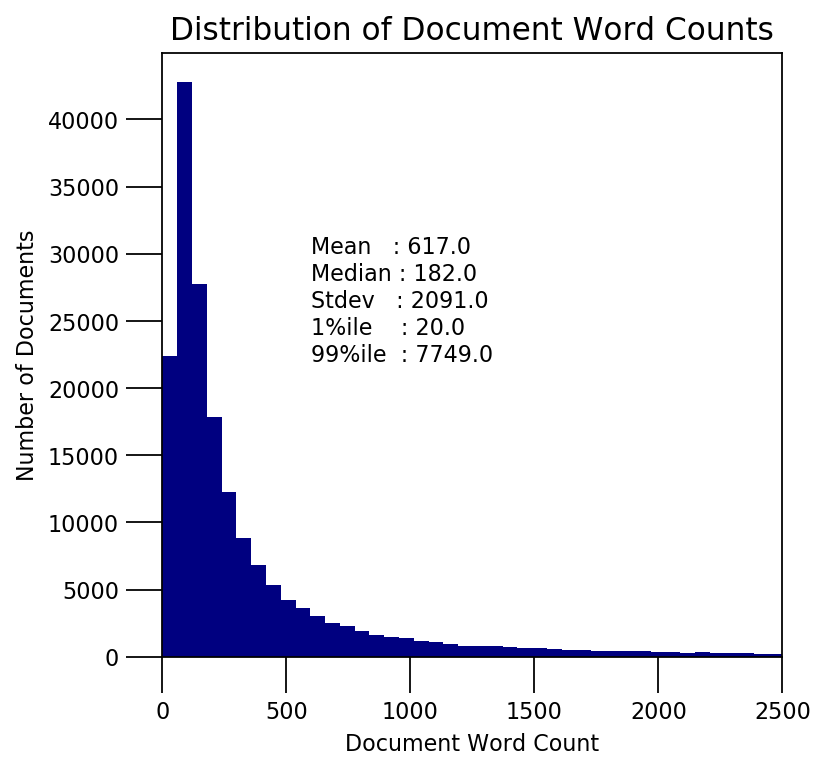

In [50]:
#Plot distribution of document word counts
doc_lens = [len(d) for d in df_merged.Text]
# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 4000, color='navy')
plt.text(600, 30000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(600, 28000, "Median : " + str(round(np.median(doc_lens))))
plt.text(600, 26000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(600, 24000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(600, 22000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
plt.gca().set(xlim=(0, 2500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.title('Distribution of Document Word Counts', fontdict=dict(size=14))
plt.show()

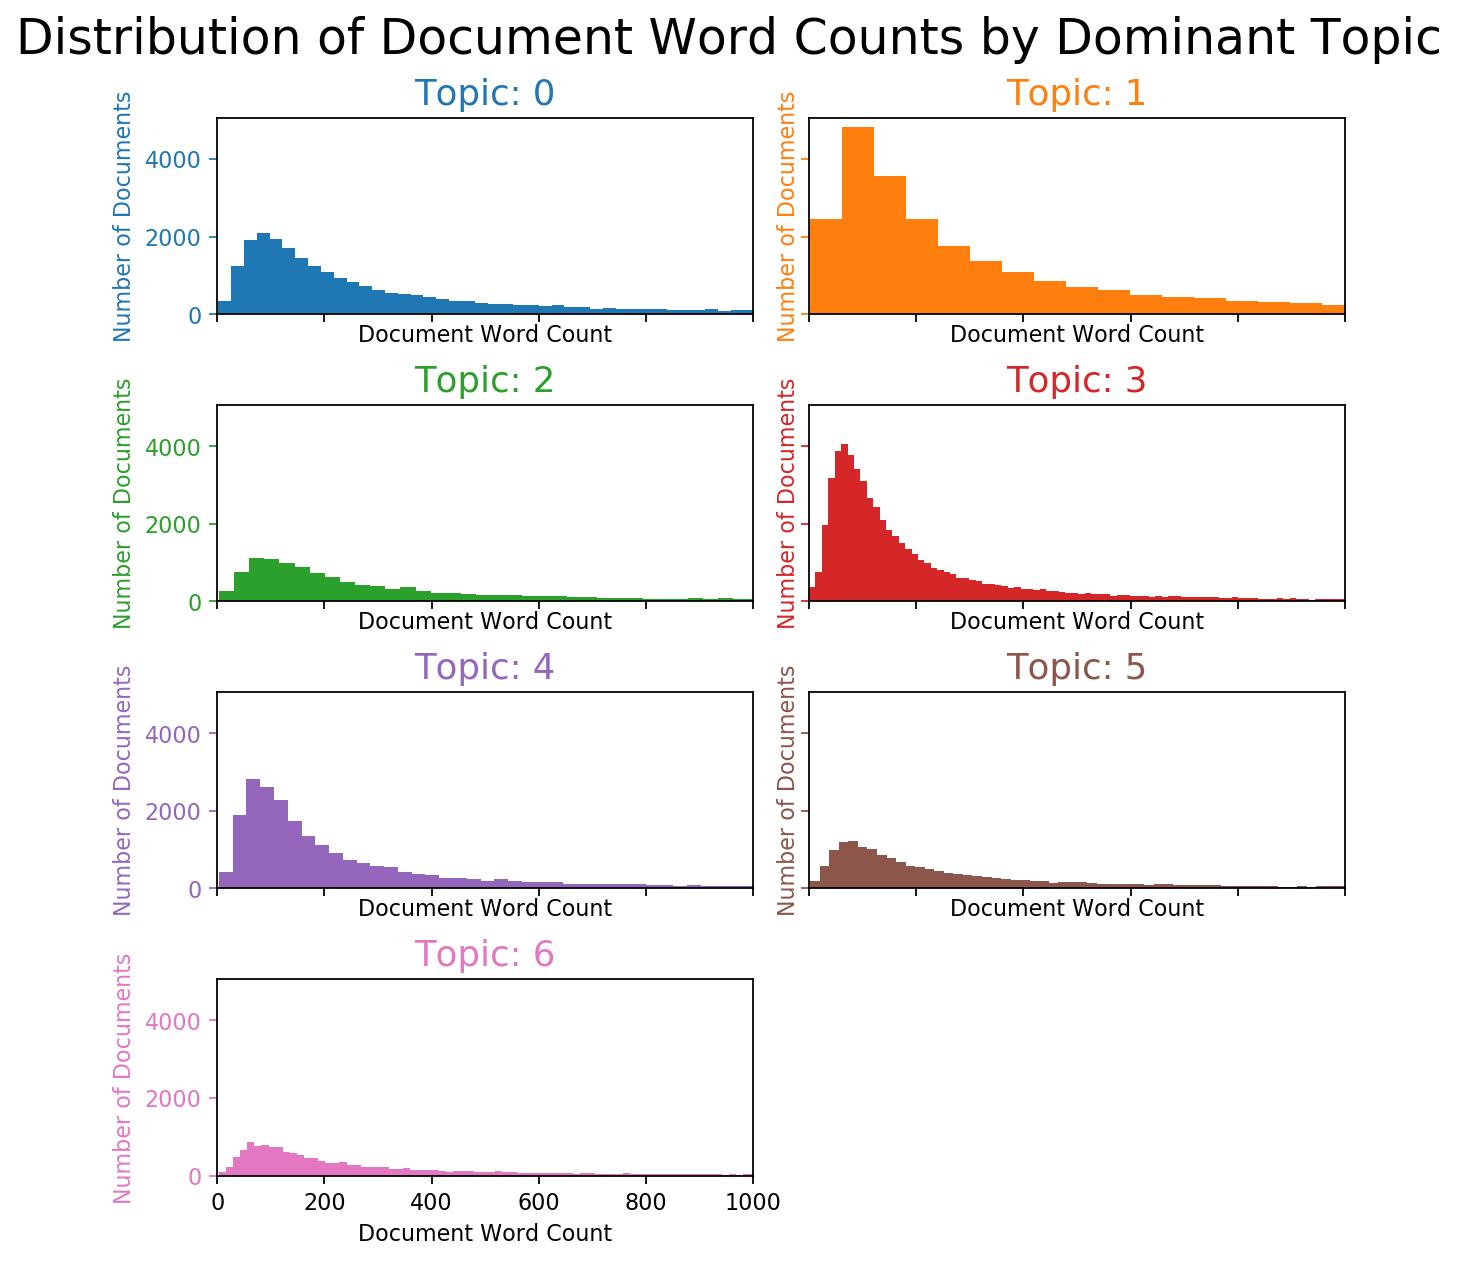

In [58]:
#Plot distribution of document word counts by dominant topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
fig, axes = plt.subplots(4,2,figsize=(8,8), dpi=160, sharex=True, sharey=True)
fig.delaxes(axes[3,1]) 
for i, ax in enumerate(axes.flatten()):  
    if(i<7):
        df_dominant_topic_sub = df_merged.loc[df_merged.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, bins = 4000, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        ax.set(xlim=(0, 1000), xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)

fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [52]:
#create a merged list of stop words
nltk_stpwd = stopwords.words('english')
#Extend stopwords with commonly found tokens in review texts
nltk_stpwd.extend(['generally', 'used', 'personally', 'review', 'honestly','truly','whatever','done','star','one','two','three','four','five','since','ever','even','much','thing','also','go','come','must'])
stop_words_stpwd = get_stop_words('en')
stop_words = list(set(nltk_stpwd + stop_words_stpwd))

print(len(set(stop_words)))
print(stop_words[:10])

234
['both', "wouldn't", 'between', 'nor', 'below', 'only', 'don', 'their', 'i', 'into']


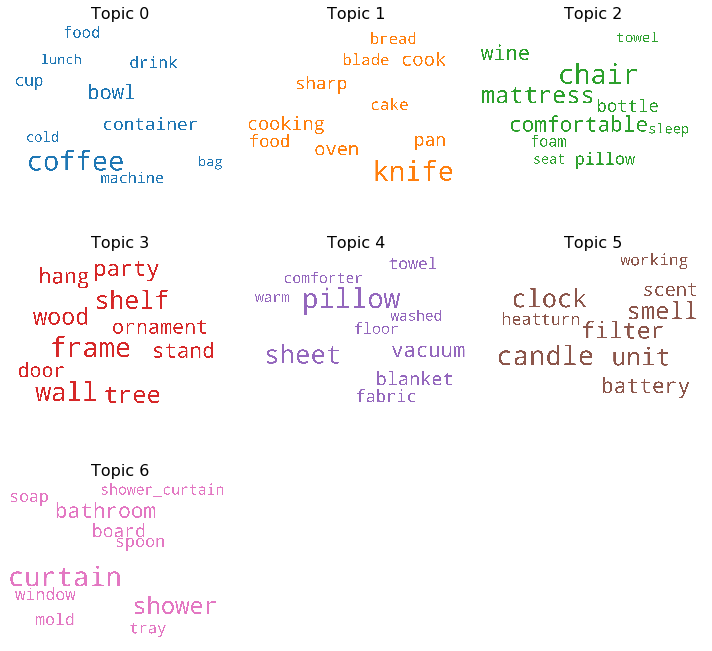

In [56]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
fig.delaxes(axes[2,1]) 
fig.delaxes(axes[2,2]) 
for i, ax in enumerate(axes.flatten()):
    if(i<7):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [32]:
#Cosine similarity measures between bag of words vectors give us similarities in the range of -1 to 1 (the greater, the more similar)
index = similarities.MatrixSimilarity(lda_model[corpus])

In [33]:
#Save preprocessed pickle file for later use
with open('index.pkl', 'wb') as f:
    pickle.dump(index, f)

In [35]:
#Find of which topic each document is composed os
corpus_lda_model = lda_model[corpus]

In [53]:
#Define recommender function
def Product_recommender(asin):
    prd_checked = 0
    for i in range(len(df_merged)):
        recommendation_scores = []
        if df_merged.asin[i] == asin:
            lda_vectors = corpus_lda_model[i]
            sims = index[lda_vectors]
            sims = list(enumerate(sims))
            for sim in sims:
                item_num = sim[0]
                recommendation_score = [df_merged.asin[item_num], sim[1]]
                recommendation_scores.append(recommendation_score)
            
            recommendation = sorted(recommendation_scores, key=lambda x: x[1], reverse=True)
            print("Your item's most prominent tokens are:")
            item_tokens = corpus[i]
            sorted_tokens = sorted(item_tokens, key=lambda x: x[1], reverse=True)
            sorted_tokens_10 = sorted_tokens[:10]
            for i in range(len(sorted_tokens_10)):
                print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                             texts_dict[sorted_tokens_10[i][0]], 
                                                             sorted_tokens_10[i][1]))
            print('-----')
            print("Your item's most prominant topic is:")
            print(lda_model.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
            print('-----')
            print('Here are your recommendations for "{}":'.format(asin))
            display(recommendation[1:11])
        
        else:
            prd_checked +=1
            
        if prd_checked == len(df_merged):
            print('Sorry, but it looks like "{}" is not available.'.format(asin))

In [54]:
Product_recommender('B00FLYWNYQ')

Your item's most prominent tokens are:
Word 1757 ("cold_weather") appears 4815.0 time(s).
Word 6221 ("need") appears 4499.0 time(s).
Word 4300 ("half") appears 3086.0 time(s).
Word 1749 ("coffee") appears 2918.0 time(s).
Word 1760 ("collagen") appears 2837.0 time(s).
Word 6224 ("needing") appears 2770.0 time(s).
Word 6909 ("planter") appears 1860.0 time(s).
Word 6575 ("overdone") appears 1627.0 time(s).
Word 5076 ("jack") appears 1424.0 time(s).
Word 3273 ("evvvveeeer") appears 1346.0 time(s).
-----
Your item's most prominant topic is:
0.021*"knife" + 0.008*"cook" + 0.008*"oven" + 0.008*"cooking" + 0.007*"pan" + 0.007*"sharp" + 0.007*"food" + 0.006*"cake" + 0.006*"blade" + 0.006*"bread"
-----
Here are your recommendations for "B00FLYWNYQ":


[['B00AZT817A', 0.9999971],
 ['B000HZGSF4', 0.9999747],
 ['B016OVE2HU', 0.9999712],
 ['B00ZLT0U96', 0.99996305],
 ['B007X5BD0G', 0.99995935],
 ['B000O8XON8', 0.9999588],
 ['B00F5C1QK6', 0.99994767],
 ['B00EXPAQUW', 0.99994636],
 ['B00HCC26Q0', 0.9999181],
 ['B01C7069MI', 0.9999181]]